In [165]:
%pylab inline
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp
import matplotlib as mpl
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import utm
jtplot.style(jtplot.infer_theme(), context='paper', fscale=2)
jtplot.figsize(x=20, y=12)

SHAPEFILES = glob.glob('./**/**/*.shp')
STREAMFLOW_META = './full_site_test_dataset_andrew.csv'

Populating the interactive namespace from numpy and matplotlib


In [166]:
def calcLatLon(northing, easting):
    from math import asin, atan2, cos, log, pow, sin, sqrt
 
    # CONSUS Albers variables (EPSG: 5070)
    RE_NAD83 = 6378137.0
    E_NAD83 = 0.0818187034 #Eccentricity
    D2R = 0.01745329251 #Pi/180
    standardParallel1 = 43.
    standardParallel2 = 47.
    centralMeridian = -114.
    originLat = 30
    originLon = 0
 
    m1 = cos(standardParallel1 * D2R)/sqrt(1.0 - pow((E_NAD83 * sin(standardParallel1 * D2R)), 2.0))
    m2 = cos(standardParallel2 * D2R)/sqrt(1.0 - pow((E_NAD83 * sin(standardParallel2 * D2R)), 2.0))
 
    def calcPhi(i):
        sinPhi = sin(i * D2R)
        return (1.0 - pow(E_NAD83, 2.0)) * ((sinPhi/(1.0 - pow((E_NAD83 * sinPhi), 2.0))) - 1.0/(2.0 * E_NAD83) * log((1.0 - E_NAD83 * sinPhi)/(1.0 + E_NAD83 * sinPhi)))
 
    q0 = calcPhi(originLat)
    q1 = calcPhi(standardParallel1)
    q2 = calcPhi(standardParallel2)
    nc = (pow(m1, 2.0) - pow(m2, 2.0)) / (q2 - q1)
    C = pow(m1, 2.0) + nc * q1
    rho0 = RE_NAD83 * sqrt(C - nc * q0) / nc
    rho = sqrt(pow(easting, 2.0) + pow((rho0 - northing), 2.0))
    q = (C - pow((rho * nc / RE_NAD83), 2.0)) / nc
    beta = asin(q / (1.0 - log((1.0 - E_NAD83) / (1.0 + E_NAD83)) * (1.0 - pow(E_NAD83, 2.0))/(2.0 * E_NAD83)))
    a = 1.0 / 3.0 * pow(E_NAD83, 2.0) + 31.0 / 180.0 * pow(E_NAD83, 4.0) + 517.0 / 5040.0 * pow(E_NAD83, 6.0)
    b = 23.0/360.0 * pow(E_NAD83, 4.0) + 251.0 / 3780.0 * pow(E_NAD83, 6.0)
    c = 761.0/45360.0 * pow(E_NAD83, 6.0)
    theta = atan2(easting, (rho0 - northing))
 
    lat = (beta + a * sin(2.0 * beta) + b * sin(4.0 * beta) + c * sin(6.0 * beta))/D2R
    lon = centralMeridian + (theta / D2R) / nc
    coords = [lat, lon]
 
    return coords
    #return coords
 
if __name__ == '__main__':
    northing = 487729.001
    easting = -254190.943
    calcLatLon(northing, easting)

In [161]:
dataframes = [gp.GeoDataFrame.from_file(shpfile) for shpfile in SHAPEFILES]
gdf = gp.GeoDataFrame(pd.concat(dataframes, ignore_index=True))
print(len(gdf))

446598


In [162]:
lat_lons = [] # np.empty((len(gdf.geometry[:]), 2))

In [163]:
for (i, point) in enumerate(gdf.geometry[:]):
    northing = point.coords.xy[1][0]  
    easting = point.coords.xy[0][0]-1500000
    [lat, lon] = calcLatLon(northing, easting)
    lat_lons.append([lat, lon])

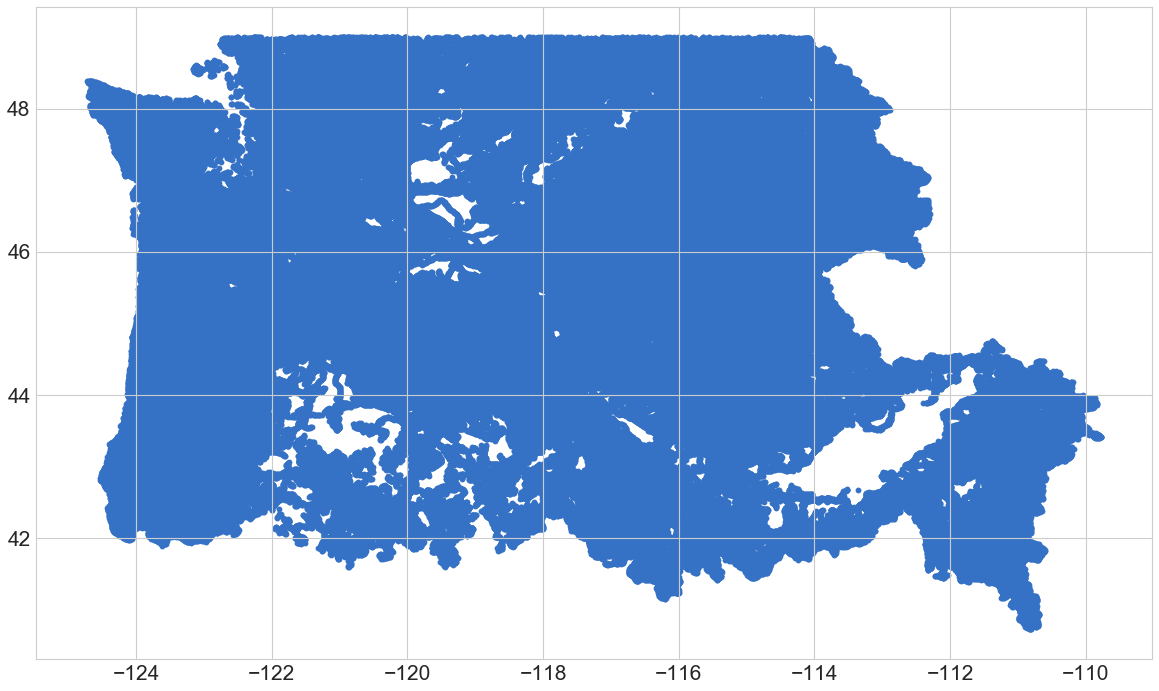

In [164]:
plt.scatter(np.array(lat_lons)[:,1]  , np.array(lat_lons)[:,0])

In [157]:
gdf.columns

Index(['OBSPRED_ID', 'FTYPE', 'WATERBODY', 'TAILWATER', 'ELEV', 'CANOPY',
       'SLOPE', 'PRECIP', 'CUMDRAINAG', 'Y_COORD', 'NLCD11PC', 'GLACIER',
       'BFI', 'Air_Aug', 'Flow_Aug', 'S1_93_11', 'S2_02–11', 'S3_1993',
       'S4_1994', 'S5_1995', 'S6_1996', 'S7_1997', 'S8_1998', 'S9_1999',
       'S10_2000', 'S11_2001', 'S12_2002', 'S13_2003', 'S14_2004', 'S15_2005',
       'S16_2006', 'S17_2007', 'S18_2008', 'S19_2009', 'S20_2010', 'S21_2011',
       'S22_PredSE', 'S23_1C', 'S24_1C_D', 'S25_2C', 'S26_2C_D', 'S27_3C',
       'S28_3C_D', 'S29_2040', 'S30_2040D', 'S31_2080', 'S32_2080D', 'COMID',
       'GNIS_NAME', 'S33_2012', 'S34_2013', 'S35_2014', 'S36_2015',
       'S37_9311M', 'S38_2040M', 'S39_2040DM', 'S40_2080M', 'S41_2080DM',
       'geometry'],
      dtype='object')

array(['Clear Creek', 'Clear Creek', 'Clear Creek', ..., None, None, None], dtype=object)

In [125]:
gdf.geometry[0].coords.xy[0][0]

1159156.7055233107

In [70]:
gdf['Y_COORD'][0]

1657127.54

In [60]:
gdf.crs = {"+proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"}

In [59]:
{'proj': 'Albers', 'ellps': 'WGS84', 'datum': 'D_North_American_1983', 'no_defs': True})

0         POINT (1159156.705523311 1657127.54341137)
1          POINT (1158630.67163082 1657707.35504472)
2        POINT (1158136.144672019 1658433.489857887)
3        POINT (1158662.720999879 1659180.348531498)
4        POINT (1158930.823415969 1660121.194459881)
5         POINT (1148665.85073478 1660963.726936541)
6        POINT (1147810.038272291 1661405.984714772)
7        POINT (1147701.000014809 1662352.245338332)
8         POINT (1150809.01655007 1659137.555902252)
9          POINT (1150571.68023701 1660020.82738593)
10        POINT (1149843.84228007 1660607.712890651)
11        POINT (1214866.60666989 1665398.478681219)
12       POINT (1214662.746733581 1666258.227161382)
13        POINT (1214532.59802028 1667236.564845685)
14          POINT (1213868.8402805 1667731.81113644)
15        POINT (1222568.99922298 1666165.452520089)
16        POINT (1149607.08241507 1666741.760345219)
17         POINT (1149876.92228526 1667623.82408303)
18        POINT (1150135.79243996 1668478.4385

In [64]:
gdf

,OBSPRED_ID,FTYPE,WATERBODY,TAILWATER,ELEV,CANOPY,SLOPE,PRECIP,CUMDRAINAG,Y_COORD,...,S33_2012,S34_2013,S35_2014,S36_2015,S37_9311M,S38_2040M,S39_2040DM,S40_2080M,S41_2080DM,geometry
0,100012,StreamRiver,0,0,2025.33,82.50,0.06903,855.5938,7.53,1657127.54,...,9.12,8.63,8.44,9.08,13.65,15.35,15.21,16.48,16.26,POINT (1159156.705523311 1657127.54341137)
1,100013,StreamRiver,0,0,1946.12,86.31,0.06903,855.5938,7.53,1657707.36,...,9.40,8.92,8.72,9.36,13.99,15.69,15.56,16.82,16.61,POINT (1158630.67163082 1657707.35504472)
2,100014,StreamRiver,0,0,1883.68,81.31,0.06903,855.5938,7.53,1658433.49,...,9.75,9.26,9.07,9.71,14.40,16.10,15.98,17.23,17.03,POINT (1158136.144672019 1658433.489857887)
3,100015,StreamRiver,0,0,1834.37,75.80,0.06903,855.5938,7.53,1659180.35,...,10.05,9.56,9.37,10.01,14.76,16.46,16.34,17.59,17.40,POINT (1158662.720999879 1659180.348531498)
4,100016,StreamRiver,0,0,1760.28,84.77,0.06903,855.5938,7.53,1660121.19,...,10.24,9.75,9.56,10.20,14.99,16.69,16.58,17.82,17.63,POINT (1158930.823415969 1660121.194459881)
5,100086,StreamRiver,0,0,1469.90,85.77,0.03646,751.2668,24.24,1660963.73,...,12.20,11.71,11.52,12.16,17.32,19.02,18.95,20.15,20.04,POINT (1148665.85073478 1660963.726936541)
6,100087,StreamRiver,0,0,1431.78,90.02,0.03646,751.2668,24.24,1661405.98,...,12.09,11.60,11.41,12.05,17.18,18.89,18.81,20.02,19.90,POINT (1147810.038272291 1661405.984714772)
7,100088,StreamRiver,0,0,1406.94,89.56,0.03646,751.2668,24.24,1662352.25,...,11.77,11.29,11.10,11.74,16.81,18.52,18.44,19.65,19.52,POINT (1147701.000014809 1662352.245338332)
8,100044,StreamRiver,0,0,1623.37,89.97,0.03919,763.3658,17.71,1659137.56,...,11.85,11.36,11.17,11.81,16.90,18.61,18.53,19.74,19.61,POINT (1150809.01655007 1659137.555902252)
9,100045,StreamRiver,0,0,1573.52,93.00,0.03919,763.3658,17.71,1660020.83,...,11.91,11.43,11.23,11.87,16.98,18.68,18.61,19.81,19.69,POINT (1150571.68023701 1660020.82738593)


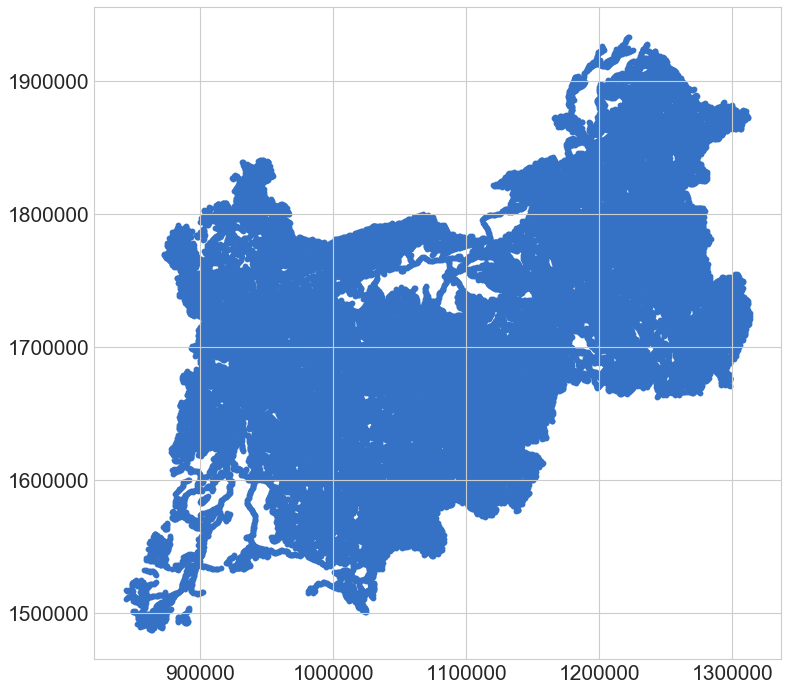

In [63]:
gdf.plot()

In [12]:
df = pd.read_csv(STREAMFLOW_META, index_col=0)
df.head()

,Basin,Location,Latitude,Longitude,Viability
Site ID,,,,,
ALB,Willamette,Albany,44.633300,-123.100000,4
BRI,Kootenay,Brilliant,49.324444,-117.620278,1
COR,Kootenay,Corra Linn,49.466944,-117.466944,3
DCD,Kootenay,Duncan,50.266667,-116.946389,2
LIB,Kootenay,Libby,48.411700,-115.309400,3
